# Using Landsat ARD

This notebook demonstrates how to retrieve and use Landsat ARD. _It is a work in progress!_

## The Python LCMAP Client

To use the client, import the `lcmap_client` module and instantiate a client object. The client uses a configuration file in your home directory `~/.usgs/lcmap.ini` to locate the LCMAP REST API.

In [1]:
from lcmap.client import Client
client = Client();

## Finding Tiles

Finding tiles requires a universal band identifier (UBID), a point, and a time interval. This will return a pair of values: a tile specification and a list of tiles.

* A UBID is a combination of mission, sensor, and band short name.
* X and Y values are in terms of projection system coordinates.
* Times are specified as ISO-8601 dates.

In the future, changes will be made to support a variety parameter types to make usage more convenient.

In [2]:
ubid = "LANDSAT_5/TM/sr_band1"
x, y = -2096625, 3095025
t1, t2 = '1985-01-01', '1985-05-01'
spec, tiles = client.data.surface_reflectance.tiles(ubid, x, y, t1, t2)

Let's examine the first tile and see how to retrieve a pixel value.

In [3]:
tile = tiles[0]

Each tile has a data property that can be used to access and, masked, scaled, and shaped set of values.

In [4]:
tile.data[0,0]

0.25019999367941637

You may also get data values in terms of the projection system coordinates. This is much more convenient than calculating the raster grid projection coordinate containing a point in the projection system on your own.

In [5]:
tiles[0][-2096625, 3095025]

0.25019999367941637

Notice that the point you specify can be "off" the implicit grid, here we move east/south by two meters. These values are _snapped_ to the nearest point.

In [6]:
tiles[0][-2096625+2, 3095025-2]

0.25019999367941637

If you needed, you can also get the acquisition date and scene ID of each tile.

In [7]:
[(t.acquired, t.source) for t in tiles]

[('1985-01-02T06:00:00Z', 'LT50470271985002XXX03'),
 ('1985-01-09T06:00:00Z', 'LT50480271985009PAC00'),
 ('1985-01-18T06:00:00Z', 'LT50470271985018XXX03'),
 ('1985-01-25T06:00:00Z', 'LT50480271985025PAC00'),
 ('1985-02-03T06:00:00Z', 'LT50470271985034PAC05'),
 ('1985-02-26T06:00:00Z', 'LT50480271985057PAC00'),
 ('1985-03-07T06:00:00Z', 'LT50470271985066PAC00'),
 ('1985-03-14T06:00:00Z', 'LT50480271985073PAC00'),
 ('1985-04-15T06:00:00Z', 'LT50480271985105XXX04')]

## Creating an Image

The client currently provides very basic functionality. If you want to render a larger image you can define a simple function to get tiles for a wider area and multiple bands. Note, this function omits the returned specs because we don't have a use for the information they contain.

In [8]:
def get_tiles(bands, x1, y1, x2, y2, t1, t2):
    xs = range(x1, x2,  256*30)
    ys = range(y1, y2, -256*30)
    results = []
    for band in bands:
        for x in xs:
            for y in ys:
                _, tiles = client.data.surface_reflectance.tiles(band, x, y, t1, t2)
                results.append(tiles)
    return results

Use the `get_tiles` function to retrieve multiple bands of data over a wide area. The returned value is a list-of-lists of tiles.

In [9]:
bands = ["LANDSAT_5/TM/sr_band3", "LANDSAT_5/TM/sr_band2", "LANDSAT_5/TM/sr_band1"]
x1, y1 = -2096625, 3095025
x2, y2 = -2096625+(256*30*2)+1, 3095025-(256*30*2)-1
t1, t2 = '1985-06-01', '1985-09-01'
tiles = get_tiles(bands, x1, y1, x2, y2, t1, t2)

### Melding Tile Data

Once we have a list-of-lists, we can meld them into three "layers" of data by defining another function. We use `numpy` and `pandas` to create this new data structure.

In [10]:
import numpy as np
from itertools import groupby

def meld(ts, ix):
    ts = [t[ix] for t in ts]
    bands = []
    for band, by_band in groupby(ts, key=lambda t: t.ubid):
        rows = []
        foo = sorted(by_band, key=lambda t: t.y, reverse=True)
        for x, by_row in groupby(foo, key=lambda t: t.y):
            bar = sorted(by_row, key=lambda t: t.x)
            data = [t.data for t in bar]
            rows.append(np.hstack(data))
        bands.append(np.vstack(rows))
    return np.dstack(bands)

### Rendering an Image

In order to render an image, we use `matplotlob` and `skimage` -- the latter has a function for color correcting images.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.cm as cm
import matplotlib.dates as mdates
import skimage.exposure as ex
import seaborn as sns
%matplotlib inline

/home/jmorton/Applications/anaconda3/lib/python3.4/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/jmorton/Applications/anaconda3/lib/python3.4/site-packages/skimage/exposure/_adapthist.py:262: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 256 but corresponding boolean dimension is 128
  hist[under] += 1
/home/jmorton/Applications/anaconda3/lib/python3.4/site-packages/skimage/exposure/_adapthist.py:263: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 256 but corresponding boolean dimension is 128
  n_excess -= hist[under].size
/home/jmorton/Applications/anaconda3/lib/python3.4/site-packages/skimage/exposure/_adapthist.py:262: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 256 but corresponding boolean dimension is

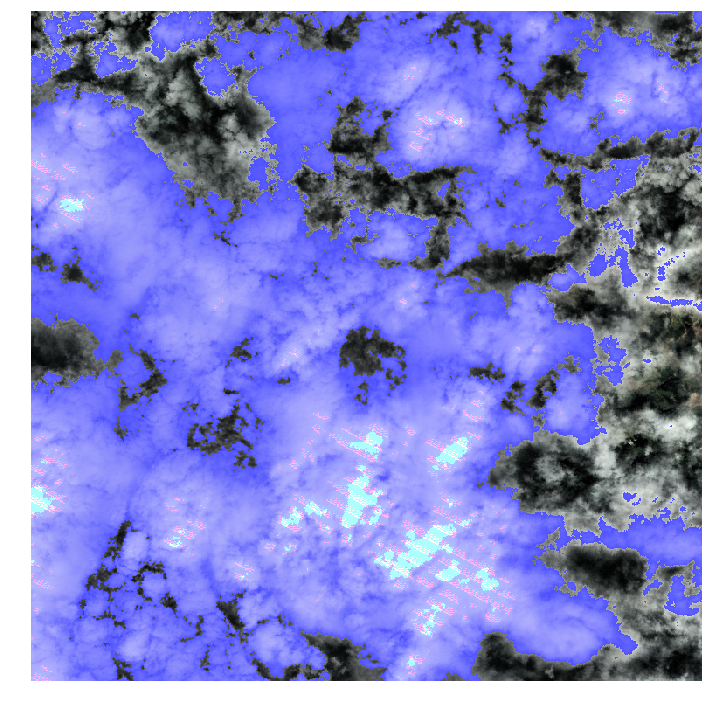

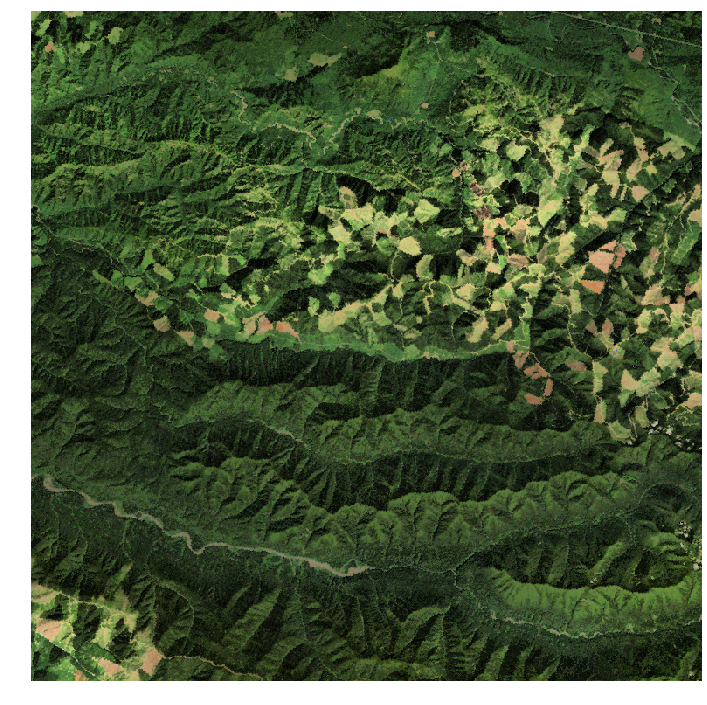

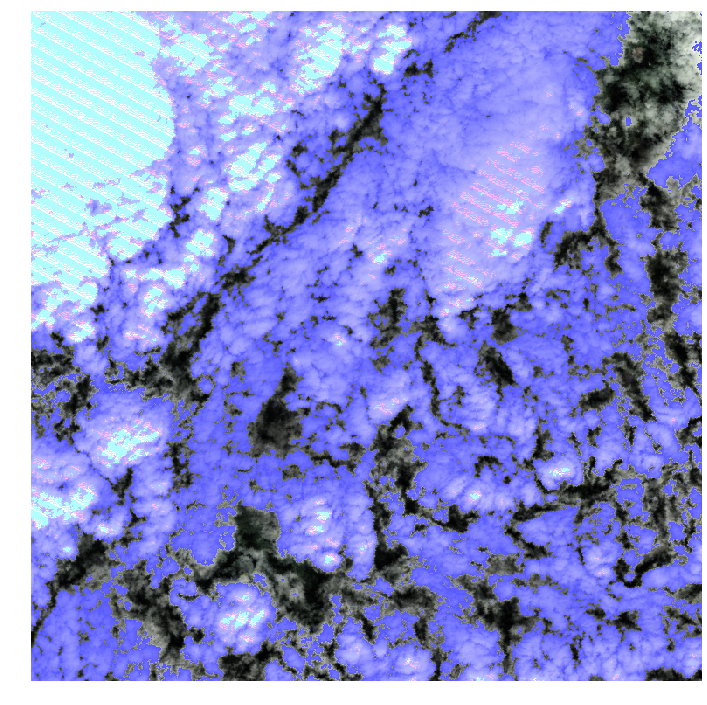

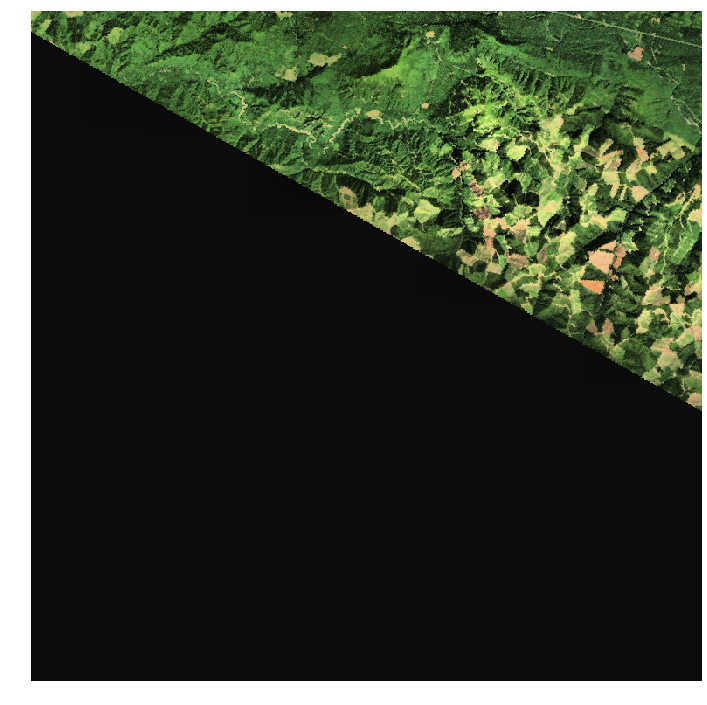

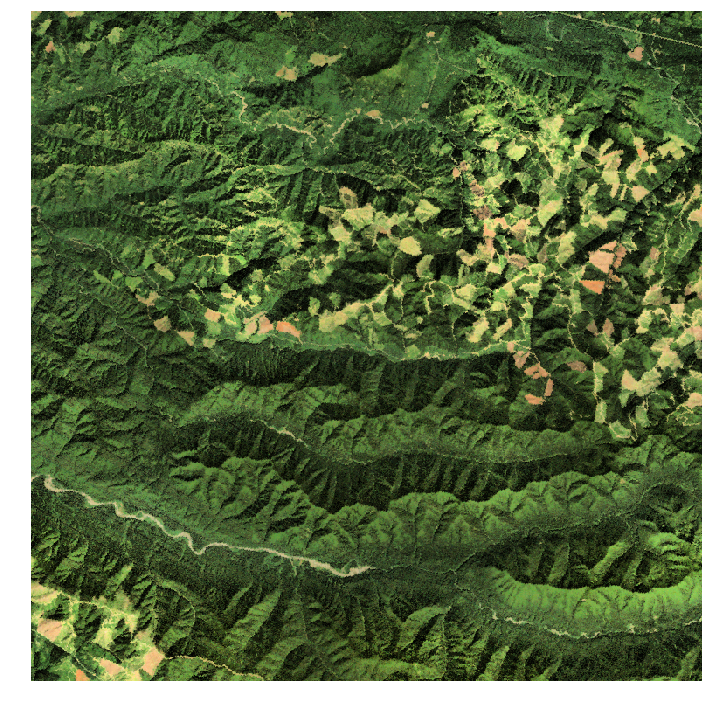

In [12]:
rgb = meld(tiles, 1)
norm = mc.Normalize(0.0, 1.0, clip=True)
rgb_ah = ex.equalize_adapthist(norm(rgb), clip_limit=0.05)
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(rgb_ah, interpolation='nearest')

## Plotting a Time Series

In [13]:
x, y = -2096625, 3095025
t1, t2 = '2001-01-01', '2003-01-01'
_, rt_L5 = client.data.surface_reflectance.tiles("LANDSAT_5/TM/sr_band3", x, y, t1, t2)
_, rt_L7 = client.data.surface_reflectance.tiles("LANDSAT_7/ETM/sr_band3", x, y, t1, t2)

In [14]:
point = 1,1 # raster grid coordinate (not projection system)
r5 = [t.data[point] for t in rt_L5]
r7 = [t.data[point] for t in rt_L7]

/home/jmorton/Applications/anaconda3/lib/python3.4/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


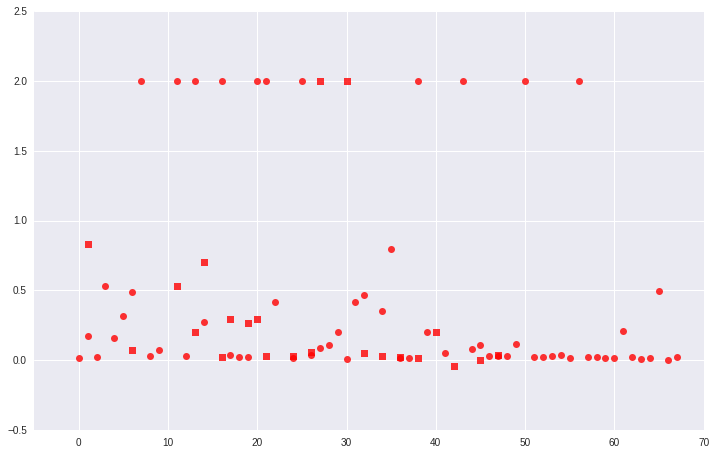

In [17]:
fig = plt.figure(figsize=(12, 7.5))
fig.hold(True)
ax = fig.add_subplot(111)
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-5, 70)
ax.plot(r5, 'rs', ms=7, alpha=0.8)
ax.plot(r7, 'ro', ms=7, alpha=0.8)
plt.show()

## Calculating NDVI

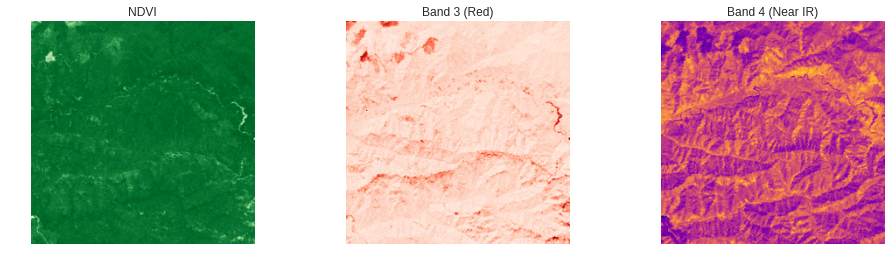

In [22]:
x, y = -2096625, 3095025
t1, t2 = '1985-06-01', '1985-07-01'
_, ir_tiles = client.data.surface_reflectance.tiles("LANDSAT_5/TM/sr_band4", x, y, t1, t2)
_, red_tiles = client.data.surface_reflectance.tiles("LANDSAT_5/TM/sr_band3", x, y, t1, t2)
 
nth = 1 # list index for picking a tile 
red, ir = red_tiles[nth].data, ir_tiles[nth].data
ndvi_calculated = (ir-red)/(ir+red)

fig = plt.figure(figsize=(16,4))
s1 = fig.add_subplot(1,3,1)
s1.axis('off')
s1.imshow(ndvi_calculated, cmap='Greens')
s1.set_title("NDVI")

s2 = fig.add_subplot(1,3,2)
s2.axis('off')
s2.imshow(red, cmap='Reds')
s2.set_title("Band 3 (Red)")

s3 = fig.add_subplot(1,3,3)
s3.axis('off')
s3.imshow(ir, cmap='plasma')
s3.set_title("Band 4 (Near IR)")

In [23]:
_, saved_ndvi = client.data.surface_reflectance.tiles("LANDSAT_5/TM/sr_ndvi", x, y, '1985-06-01', '1985-07-01')

In [25]:
ndvi_calculated[0,0], saved_ndvi[nth].data[0,0]

(0.57876210032267528, 0.57879998537828214)

In [26]:
ndvi_calculated[128,128], saved_ndvi[nth].data[128,128]

(0.82935352358765291, 0.82939997904759366)